# "Into the INFERNO: parameter estimation under uncertainty - Part 4"
> "In this series of posts, we'll be looking at one of the most common problems in high-energy physics; that of estimating some parameter of interest. In this fourth post we'll apply the INFERNO method to the problem we studied last time, to see how if improves our measurement in the presence of systematic uncertainties."

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [statistics, HEP, INFERNO]
- image: images/copied_from_nb/imgs/inferno/inferno_systs.png
- hide: false
- search_exclude: false

![binning comparison](imgs/inferno/inferno_systs.png)

Welcome back to the fourth part of this blog-post series. In case you missed the previous posts: [first](https://gilesstrong.github.io/website/statistics/hep/inferno/2020/12/04/inferno-1.html), [second](https://gilesstrong.github.io/website/statistics/hep/inferno/2020/12/11/inferno-2.html), and [third](https://gilesstrong.github.io/website/statistics/hep/inferno/2020/12/18/inferno-3.html). This post will continue on from part-3, so I'd recommend re-reading that first, anyway.

Last time we worked through the toy-example presented in the [INFERNO](https://www.sciencedirect.com/science/article/pii/S0010465519301948) paper, and demonstrated how the typical approach in HEP would go about solving it. We then went on to see how the presence of nuisance parameters in the feature distributions or yield normalisations can really spoil the precision of our measurement. Now let's use INFERNO to tackle the same problem!

As a reminder, we're using a PyTorch implementation of INFERNO which I've put together. The package can be installed using:

In [ ]:
!pip install pytorch_inferno==0.0.1

Docs are located [here](https://gilesstrong.github.io/pytorch_inferno/) and the Github repo is [here](https://github.com/GilesStrong/pytorch_inferno). I'm installing v0.0.1 here, since it was what I used when writing this post, but for your own work, you should grab the latest version.

As an additional note, these blog posts are fully runnable as Jupyter notebooks. You can either download them, or click the Google Colab badge at the top to follow along!

## Recap

Put simply, INFERNO aims to provide a loss function for the network that fully captures the nature of inference problem and directly optimises the network according to the final metric; the precision of the parameter estimate. First, though, let's recap our approach from the last post to remind ourselves what this involves: First we trained a binary classifier for signal and background, mapping the 3 input features down to a single class prediction in which the two classes display high linear separation.

In the presence of no nuisance parameters:
1. We binned the predictions and normalised to get PDFs of the signal ($f_s$) and background ($f_b$)
1. The PDFs were then renormalised according to:
    1. Expected the signal and background yields: the Asimov dataset $N_{a,i}=50\cdot f_{s,i}+1000\cdot f_{b,i}$
    1. The expected background and a range of signal strengths $N_{\mu,i}=\mu\cdot f_{s,i}+1000\cdot f_{b,i}$
1. The negative log-likelihood of the Poisson model computed at the Asimov count was evaluated for the range of signal strengths $NLL(\mu)=-\sum_i\left[\ln\left[\frac{N_{\mu,i}^{N_{a,i}}}{N_{a,i}!}e^{N_{\mu,i}}\right]\right]$
1. The uncertainty on the signal strength $\mu$ was computed as half the width of the NLL scan at the points 0.5 greater than the minimum value (the 1-sigma interval)

In the presence of systematics:
1. 1-sigma up/down shifts in the input features were computed
1. The DNN predictions for shifted inputs were computed, along with the nominal shapes normalised and binned to get PDFs of the signal ($f_s$) and background ($f_{b,\theta}$)
1. The PDFs were then renormalised according to:
    1. Expected the signal and background yields: the Asimov dataset $N_{a,i}=50\cdot f_{s,i}+1000\cdot f_{b,i}$
    1. The expected background and a range of signal strengths and an uncertain background $N_{\mu,\theta,n_b,i}=\mu\cdot f_{s,i}+n_b\cdot f_{b,\theta,i}$
1. The negative log-likelihood of the Poisson model computed at the Asimov count was evaluated for the range of signal strengths $NLL(\mu,\theta,n_b)=-\sum_i\left[\ln\left[\frac{N_{\mu,\theta,n_b,i}^{N_{a,i}}}{N_{a,i}!}e^{N_{\mu,\theta,n_b,i}}\right]\right]$
1. The NLL values were then adjusted according to any auxiliary measurements on the nuisances, e.g. $NLL\rightarrow NLL-C$, where $C$ could be e.g. a log-normal PDF evaluated at the proposed $\theta$ value
1. The NLL values were then minimised separately for each value of $\mu$ by optimising the nuisance parameters though Newtonian updates based on the first- and second-order derivatives of the NLL w.r.t. to the nuisances. (Nuisances affecting the shape of the inputs features were interpolated between the up/down 1-sigma template shifts).
1. The uncertainty on the signal strength $\mu$ was computed as half the width of the optimised NLL scan at the points 0.5 greater than the minimum value (the 1-sigma interval)

## The INFERNO loss

INFERNO effectively performs the entire loop above, but with a few simplifications to help speed it up. In order to function as a loss, we need the final value to be a single number which can be differentiated w.r.t. the network parameters. The loss also needs to represent the width of the NLL scan, and take into account the effect of nuisance parameters. 

As said, we want to quantify the width of the NLL scan without having to compute the full scan and optimise the nuisance parameters. Instead, let's compute the NLL at the nominal values of the parameters and consider this point in the parameter space (i.e. the NLL surface projected in $(\mu,\theta)$ space). Since we computed the NLL at the nominal parameter values (in our example $\mu=50$, $n_b$=1000, and $\bar{\theta}=\bar{0}$), we are therefore at the minimum, and $\nabla NLL=0$. However the second-order derivatives will not be zero. $\partial^2_\mu NLL$ will characterise how quickly the NLL surface becomes steep along the $\mu$ direction. The greater that $\partial^2_\mu NLL$ is, the thinner the width at $0.5+\min NLL$, and so the precision on $\mu$ increases. Similarly, $\partial^2_\theta NLL$ will characterise the effect of the nuisances on the NLL surface.

Computing the full Hessian of the NLL w.r.t. the parameter of interest and the nuisances we get a matrix of the form:

$$I=\begin{bmatrix}
\partial_{\mu\mu} NLL & \partial_{\mu n_b} NLL & \partial_{\mu\theta} NLL \\
\partial_{n_b\mu} NLL & \partial_{n_b n_b} NLL & \partial_{n_b\theta} NLL \\
\partial_{\theta\mu} NLL & \partial_{\theta n_b} NLL & \partial_{\theta\theta} NLL \\
\end{bmatrix}$$

This is referred to as the Fisher information matrix $I$.

The diagonal elements charaterise the expected variance of each parameter, and the off-diagonal elements characterise the interactions between the parameters. Inverting the Hessian and then taking the $\mu\mu$ element provides us with a single value whose minimisation will lead to a narrowing to the NLL width in $\mu$, whilst accounting for the interactions between $\mu$ and the nuisance parameters. Note that this is **not** the same as taking the reciprocal of the $\mu\mu$ element of the Hessian, since that ignores the effect of the nuisance parameters.

Our loss is therefore $(I^{-1})_{0,0}$ (where the parameter of interest, $\mu$, is the zeroth element)

### Soft binning


One problem, though, is that our usual approach to computing NLL relies on binning the output of the network. Such an approach here would not allow the loss to be differentiable.

The approach taken by INFERNO is to mimic the binning by having multiple outputs for the DNN. A softmax output activation function is then used to normalise the sum of outputs per datapoint to be one, effectively providing a soft-assignment of the datapoints to each of the 'bins'. The inputs to the softmax can be multiplicatively rescaled to better approximate a hard assignment to a given bin, whilst still allowing the loss to be differentiated.

Note that in this case, in might be more intuitive to think of each output of the DNN not as a bin in a histogram, but as an abstract class (or cluster) of datapoints which emerge as a function of the training: certainly there is no reason to expect the outputs to exhibit any form of ordering, like a histogram might, and due to the random initialisation of the network parameters, no two trainings will result in the same output densities.

One could expect, though, that the learned clustering would instead follow differing densities of signal and background based on confidence in assignment (e.g. strongly expect signal, strongly expect background, and reasonably signal-like), the stringency of which varies according to the yields of signal and background, and any uncertainties on them. Effectively, the network is allowed to learn its own binning of the data for the particular inference task at hand.

## INFERNO implementation

### Variable Softmax for binning

The softmax activation performs the following operation:
    
$$\sigma(\bar{x})_i = \frac{e^{x_i}}{\sum_j e^{x_j}}$$

i.e. it normalises each output of the network $x_i$ according to the all outputs $\bar{x}$, such that $\sum_i\sigma(\bar{x})_i=1$

As an example:

In [2]:
from torch import Tensor, nn
nn.Softmax(dim=-1)(Tensor([1,2,3]))

tensor([0.0900, 0.2447, 0.6652])

The output vector gets normalised to one, with each input element having a proportionate representation in the output. Since we are using the softmax to simulate the hard assignment of predictions to bins, however, we want to magnify any slight differences in the predictions, such that the largest input to the softmax has a greater than proportional representation in the output. This can be achieved by rescaling the inputs prior to the softmax ([VariableSoftmax](https://gilesstrong.github.io/pytorch_inferno/inferno_exact.html#VariableSoftmax)):

```python
class VariableSoftmax(nn.Softmax):
    r'''Softmax with temperature'''
    def __init__(self, temp:float=1, dim:int=-1):
        super().__init__(dim=dim)
        self.temp = temp
        
    def forward(self, x:Tensor) -> Tensor: return super().forward(x/self.temp)
```

In [3]:
from pytorch_inferno.inferno import VariableSoftmax
VariableSoftmax(0.1)(Tensor([1,2,3]))

tensor([2.0611e-09, 4.5398e-05, 9.9995e-01])

Now the first two elements have basically no representation, and the entire datapoint is effectively assigned to the last 'bin'. N.B. This rescaling could potentially be learnt by the network during training, however by setting the rescaling ourselves, we still allow the network to learn an optimal rescaling, but in a way which keeps the output of the last linear layer close to a standard deviation of one.

### Loss-DNN class interaction

Implementation of the INFERNO loss requires a slightly more complex interaction between the loss and the DNN, than other, more basic, losses. This potentially makes it difficult to integrate into a traditional training configuration which expects to just pass predictions to the loss function and get back the loss value.

The training setup included in [pytorch_inferno](https://gilesstrong.github.io/pytorch_inferno/) includes an extended integration of callbacks (inspired by [fastai](https://course19.fast.ai/videos/?lesson=10)). Let's look at the fitting function code included in the [ModelWrapper](https://gilesstrong.github.io/pytorch_inferno/model_wrapper.html#ModelWrapper) class:

```python
def fit(self, n_epochs:int, data:DataPair, opt:Callable[[Generator],optim.Optimizer],
            loss:Optional[Callable[[Tensor,Tensor],Tensor]], cbs:Optional[Union[AbsCallback,List[AbsCallback]]]=None) -> None:
        def fit_epoch(epoch:int) -> None:
            self.model.train()
            self.state = 'train'
            self.epoch = epoch
            for c in self.cbs: c.on_epoch_begin()
            for b in progress_bar(self.data.trn_dl, parent=self.mb): self._fit_batch(*b)
            for c in self.cbs: c.on_epoch_end()

            self.model.eval()
            self.state = 'valid'
            for c in self.cbs: c.on_epoch_begin()
            for b in progress_bar(self.data.val_dl, parent=self.mb): self._fit_batch(*b)
            for c in self.cbs: c.on_epoch_end()
            
        if cbs is None: cbs = []
        elif not is_listy(cbs): cbs = [cbs]
        self.cbs,self.stop,self.n_epochs = cbs,False,n_epochs
        self.data,self.loss_func,self.opt = data,loss,opt(self.model.parameters())
        for c in self.cbs: c.set_wrapper(self)
        for c in self.cbs: c.on_train_begin()
        self.mb = master_bar(range(self.n_epochs))
        for e in self.mb:
            fit_epoch(e)
            if self.stop: break
        for c in self.cbs: c.on_train_end()
```

and the `_fit_batch` function:

```python
def _fit_batch(self, x:Tensor, y:Tensor, w:Tensor) -> None:
    self.x,self.y,self.w = to_device(x,self.device),to_device(y,self.device),to_device(w,self.device)
    for c in self.cbs: c.on_batch_begin()
    self.y_pred = self.model(self.x)
    if self.state != 'test' and self.loss_func is not None:
        self.loss_func.weights = self.w
        self.loss_val = self.loss_func(self.y_pred, self.y)
    for c in self.cbs: c.on_forwards_end()
    if self.state != 'train': return

    self.opt.zero_grad()
    for c in self.cbs: c.on_backwards_begin()
    self.loss_val.backward()
    for c in self.cbs: c.on_backwards_end()
    self.opt.step()
    for c in self.cbs: c.on_batch_end()
```

Throughout the training loop, there are lines of the form `for c in self.cbs: c.on_batch_end()`. These allow the callbacks to act at appropriate times during the training.

Three important things to note are:
1. `for c in self.cbs: c.set_wrapper(self)` means that every callback class has direct access to the DNN (and any other callbacks)
1. `self.x,self.y,self.w = to_device(x,self.device),to_device(y,self.device),to_device(w,self.device)` means that the data for the minibatch are properties of the model, and so can be accessed and affected by the callbacks
1. `if self.state != 'test' and self.loss_func is not None:` means we can set the loss function to `None`, and manually set the value of `self.loss_val` within a callback.

The INFERNO loss in pytorch_inferno is therefore implemented as a [callback](https://gilesstrong.github.io/pytorch_inferno/callback.html#AbsCallback) and so gains access to an extra level of integration with the training loop. There is an [abstract class](https://gilesstrong.github.io/pytorch_inferno/inferno_exact.html#AbsInferno) implementing the basic functionality, and the idea is that users can inherit from it to apply to their specific problems, e.g in our case [PaperInferno](https://gilesstrong.github.io/pytorch_inferno/inferno_exact.html#PaperInferno). Note however that even the "abstract" class is still designed for a Poisson counting problem.

### Abstract implementation

Let's go through the code function by function:
```python
class AbsInferno(AbsCallback):
    def __init__(self, n:int, true_mu:float, n_alphas:int=0, float_b:bool=False,
                 alpha_aux:Optional[List[Distribution]]=None, b_aux:Optional[Distribution]=None):
        super().__init__()
        store_attr()
        self.true_b = self.n-self.true_mu
```

We initialise the class with the Asimov count `n`, and the true signal strength `true_mu`. The true background count is then computed automatically. `n_alphas` is the number of shape systematics to expect and `float_b` is whether or not the background normalisation should be allowed to vary. Any auxiliary measurements for the shape parameters and background yield can be passed as PyTorch distributions to the `alpha_aux` and `b_aux` arguments.

```python
def on_train_begin(self) -> None:
    self.wrapper.loss_func = None
    for c in self.wrapper.cbs:
        if hasattr(c, 'loss_is_meaned'): c.loss_is_meaned = False
    self.alpha = torch.zeros((self.n_alphas+1+self.float_b), requires_grad=True, device=self.wrapper.device)
    with torch.no_grad(): self.alpha[0] = self.true_mu
```

This is called whenever the training starts. It ensures that the model doesn't have a loss function already, and ensures that any other callbacks will correctly average the loss for early-stopping, model saving, and real-time feedback. Finally, we cache a tensor for the nuisance parameters. The zeroth element will be our parameter of interest, which we set to the true value in way that doesn't affect the stored gradient.

```python
def on_batch_begin(self) -> None:
    self.b_mask = self.wrapper.y.squeeze() == 0
    self.aug_data(self.wrapper.x)
```

This is called just before a minibatch is passed through the network. `self.wrapper.y` are the true target values, and so `self.b_mask` is a Boolean mask of all the background datapoints (we cache it now, since it is used at several points). `self.aug_data` is an abstract method, which must be overriden in the problem-specific inheriting class. This is a key function since it allows the effect of shape-nuisances to have derivatives w.r.t. the network parameters. Let's quickly jump to see how it is implemented for the INFERNO paper problem:

```python
def aug_data(self, x:Tensor) -> None:
    if self.float_r: x[self.b_mask,0] += self.alpha[1+self.float_b]  # If float_b, alpha_r is element 2 not 1
    if self.float_l: x[self.b_mask,2] *= (self.alpha[-1]+self.l_init)/self.l_init
```

As discussed in [part-3 ](https://gilesstrong.github.io/website/statistics/hep/inferno/2020/12/18/inferno-3.html#Nuisance-parameters), due to the construction of the problem, we know analytically the exact effects of our two shape nuisances on the input data: a shift in $r$ causes a linear shift in zeroth input feature values, and a change in $\lambda$ leads to a rescaling of the second input feature. `x` is the incoming minibatch, and we use the cached background mask to only affect the background data.

Note that elements of `self.alpha` that are indexed are all zero: therefore `aug_data` data never actually modifies the values of the input data, instead we are adding 'the potential to be modified by the nuisance parameters', which allows the NLL to be differentiated w.r.t. the shape nuisances without having interpolate the shapes from up/down 1-sigma templates. Of course, this relies on knowing the analytical (or well modelled) effect of the nuisances in the input features, and in part 5 we'll look at a way around this.

Having passed the input data through the network, we call:
```python
def on_forwards_end(self) -> None:
    r'''Compute loss and replace wrapper loss value'''
    def to_shape(p:Tensor) -> Tensor:
        f = p.sum(0)+1e-7
        return f/f.sum()

    f_s = to_shape(self.wrapper.y_pred[~self.b_mask])
    f_b = to_shape(self.wrapper.y_pred[self.b_mask])
    f_b_asimov = to_shape(self.wrapper.model(self.wrapper.x[self.b_mask].detach())) if len(self.alpha) > 1 else f_b
    self.wrapper.loss_val = self.get_inv_ikk(f_s=f_s, f_b=f_b, f_b_asimov=f_b_asimov)
```

This extracts the normalised shapes for signal and background (their PDFs) from the network predictions (`self.wrapper.y_pred`). The background predictions will include the shape nuisances, so in order to get the Asimov shape for background (which shouldn't be affected by nuisances), we need to detach the background inputs (removes the nuisance parameters) and pass it through the network again. Finally, we compute the loss (detailed below) and set the loss value of the model manually.

```python
def get_inv_ikk(self, f_s:Tensor, f_b:Tensor, f_b_asimov:Tensor) -> Tensor:
        r'''Compute full hessian at true param values'''
        b_exp = self.true_b+self.alpha[1] if self.float_b else self.true_b
        t_exp  = (self.alpha[0]*f_s)+(b_exp*f_b)
        asimov = (self.true_mu*f_s)+(self.true_b*f_b_asimov)
        nll = -torch.distributions.Poisson(t_exp).log_prob(asimov).sum()
        if self.alpha_aux is not None:  # Constrain shape nuisances
            if len(self.alpha_aux) != self.n_alphas: raise ValueError("Number of auxillary measurements must match the number of nuisance parameters")
            for a,x in zip(self.alpha[1+self.float_b:], self.alpha_aux):  # Constrain shapes
                if x is not None: nll = nll-x.log_prob(a)
        if self.b_aux is not None: nll = nll-self.b_aux.log_prob(b_exp)
        _,h = calc_grad_hesse(nll, self.alpha, create_graph=True)
        return torch.inverse(h)[0,0]
```

Here we compute the Fisher information matrix of the negative log-likelihood, invert it, and return the element corresponding to our parameter of interest. If the background yield is uncertain, then the 'potential to be modified' is added using the alpha tensor (`self.alpha[1]` is zero, but the tensor tracks gradients). Next we compute the expected and Asimov yields per bin `t_exp` and `asimov`. These will have the same values, the difference is that `t_exp` can be affected by changes in the nuisance parameters, `alpha`, but `asimov` cannot. We then compute the NLL as normal, and add any constraints due to auxiliary measurements. [calc_grad_hesse](https://gilesstrong.github.io/pytorch_inferno/inference.html#calc_grad_hesse) returns the Hessian (Fisher information matrix), which we then invert and return the $\mu\mu$ element of.

## DNN training

We train the network in a similar fashion as in [part-3](https://gilesstrong.github.io/website/statistics/hep/inferno/2020/12/18/inferno-3.html#Classifier-training), except we want to increase the batch size since we need to have an accurate representation of the bin populations to prevent statisitical fluctuations in the loss. The paper uses a batch size of 2000, 10 outputs, and a softmax temperature of 0.1.

In [19]:
from pytorch_inferno.utils import init_net
from pytorch_inferno.model_wrapper import ModelWrapper

def get_model() -> ModelWrapper:
    net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                        nn.Linear(100,100),nn.ReLU(),
                        nn.Linear(100,10),  VariableSoftmax(0.1))
    init_net(net)  # Initialise weights and biases
    return ModelWrapper(net)    

In [20]:
from pytorch_inferno.data import get_paper_data
data, test = get_paper_data(n=200000, bs=2000, n_test=1000000)

As mentioned above, we need to specify a concrete implementation of INFERNO for our specific problem. pytorch_inferno already includes a class for the paper example: [PaperInferno](https://gilesstrong.github.io/pytorch_inferno/inferno_exact.html#PaperInferno).

``` python
class PaperInferno(AbsInferno):
    r'''Inheriting class for dealing with INFERNO paper synthetic problem'''
    def __init__(self, float_r:bool, float_l:bool, l_init:float=3, n:int=1050, true_mu:int=50, float_b:bool=False,
                 alpha_aux:Optional[List[Distribution]]=None, b_aux:Optional[Distribution]=None):
        super().__init__(n=n, true_mu=true_mu, n_alphas=float_r+float_l, float_b=float_b, alpha_aux=alpha_aux, b_aux=b_aux)
        self.float_r,self.float_l,self.l_init = float_r,float_l,l_init
        
    def aug_data(self, x:Tensor) -> None:
        if self.float_r: x[self.b_mask,0] += self.alpha[1+self.float_b]  # If float_b, alpha_r is element 2 not 1
        if self.float_l: x[self.b_mask,2] *= (self.alpha[-1]+self.l_init)/self.l_init
```

This contains options for floating different parameters of the model and allows us to define specific losses for each of the benchmark problems in the paper. In part-3, we evaluated our cross-entropy DNN against benchmarks 0, 2, 3, and 4. The paper results (table 2), however show that a model trained using INFERNO specified for benchmark 4 performs nearly as well on other benchmark problems as models trained specifically for that benchmark. To save time, then we'll just train for benchmark 4, now, but you can run this notebook yourself to check out the other trainings.

In [21]:
from pytorch_inferno.inferno import PaperInferno
from torch import distributions
inferno = PaperInferno(float_l=True,  # Let lambda be a shape nuisance
                       float_r=True,  # Let r be a shape nuisance
                       float_b=True,  # Let the background yield be a nusiance
                       alpha_aux=[distributions.Normal(0,2), distributions.Normal(0,2)],  # Include auxiliary measurements on r & lambda
                       b_aux=distributions.Normal(1000,100))  # Include auxiliary measurements on the background yield

Now let's train the model. In contrast to the paper, we'll use ADAM for optimisation, at a slightly higher learning rate, to save time. We'll also avoid overtraining by saving when the model improves using [callbacks](https://gilesstrong.github.io/pytorch_inferno/callback.html). Note that we don't specify a loss argument.

In [23]:
from fastcore.all import partialler
from torch import optim
from pytorch_inferno.callback import LossTracker, SaveBest, EarlyStopping
model = get_model()
model.fit(200, data=data, opt=partialler(optim.Adam,lr=8e-5), loss=None,
          cbs=[inferno,LossTracker(),SaveBest('weights/best_inferno.h5'),EarlyStopping(5)])

1: Train=3912.3916760253906 Valid=2806.8546923828126
2: Train=1746.002896118164 Valid=1328.9496655273438
3: Train=1223.951845703125 Valid=1056.1231018066405
4: Train=916.6781005859375 Valid=825.12619140625
5: Train=828.3240393066407 Valid=756.0421423339844
6: Train=786.2163452148437 Valid=720.3921081542969
7: Train=730.0841842651367 Valid=695.8928698730468
8: Train=707.7799942016602 Valid=668.0408581542969
9: Train=672.0432852172852 Valid=643.1469519042969
10: Train=652.324967956543 Valid=623.7019995117188
11: Train=630.8129745483399 Valid=625.9892742919922
12: Train=604.371823425293 Valid=592.8834387207031
13: Train=596.728298034668 Valid=587.4838079833985
14: Train=584.1115322875977 Valid=579.2229278564453
15: Train=581.4167013549804 Valid=555.0884375
16: Train=559.1637445068359 Valid=584.8051611328125
17: Train=555.4294171142578 Valid=539.6500164794921
18: Train=558.395673828125 Valid=527.4596801757813
19: Train=531.9894320678711 Valid=527.0246984863281
20: Train=528.8188244628906 V

Having trained the model, we can now check the predictions on the test set, however the model currently outputs probabilities for each class and datapoint, but our inference setup requires a single number per datapoint (the bin index), so we want to perform a hard assignment of data to bins via an $\arg\max$ operation. The prediction methods of the [ModelWrapper](https://gilesstrong.github.io/pytorch_inferno/model_wrapper.html#ModelWrapper) allow us to pass a callback to affect to the predictions of the model without us having to process them manually ourselves. [InfernoPred]() will perform the hard assignment, turning the predictions into single numbers.

```python
class InfernoPred(PredHandler):
    r'''Prediction handler for hard assignments'''
    def get_preds(self) -> np.ndarray: return np.argmax(self.preds, 1)
```

Note that potentially we could stick with a soft assignment, in which datapoints are split across several bins by different amounts, however generally in HEP people try to avoid messing with the *real collider data*, so we'll stick with hard assignments for now.

In [25]:
from pytorch_inferno.inferno import InfernoPred
preds = model._predict_dl(test, pred_cb=InfernoPred())

In [26]:
import pandas as pd
df = pd.DataFrame({'pred':preds.squeeze()})
df['gen_target'] = test.dataset.y
df.head()

,pred,gen_target
0,0,1.0
1,3,1.0
2,6,1.0
3,1,1.0
4,1,1.0


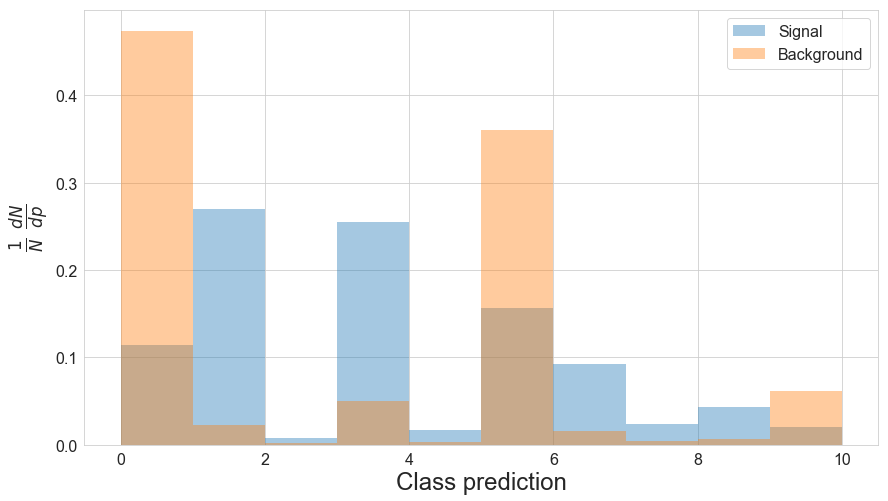

In [28]:
from pytorch_inferno.plotting import plot_preds
import numpy as np
plot_preds(df, bin_edges=np.linspace(0,10,11))

From the above plot, we can see that as expected, the bins don't display any form of ordering, but rather varying densities of class population. One possible interpretation might be that the DNN found it optimal to have a few bins with a strong presence of background, and instead split the signal over a range of bins, each with weaker amounts of background

## Parameter estimation

Now we can run the benchmark tests as before. The predictions are already binned, we just need to rename the column to allow it to work with the inference code

In [30]:
df['pred_bin'] = df.pred

In [33]:
from pytorch_inferno.inference import get_shape
f_s,f_b = get_shape(df,targ=1),get_shape(df,targ=0)  # Gets normalised shape for each class
f_s,f_b

(tensor([0.1145, 0.2698, 0.0076, 0.2550, 0.0169, 0.1566, 0.0922, 0.0237, 0.0433,
         0.0204]),
 tensor([0.4742, 0.0227, 0.0024, 0.0498, 0.0028, 0.3600, 0.0153, 0.0046, 0.0071,
         0.0611]))

### Benchmark 0 - No nuisance parameters

In [38]:
asimov = (50*f_s)+(1000*f_b)
asimov, asimov.sum()

(tensor([479.8850,  36.1540,   2.8191,  62.5361,   3.6305, 367.8640,  19.9573,
           5.8051,   9.2734,  62.0755]), tensor(1049.9999))

Now we can compute the negative loglikelihood for a range of $\mu$ values, as usual

In [39]:
import torch
n = 1050
mu = torch.linspace(20,80,61)
nll = -torch.distributions.Poisson((mu[:,None]*f_s)+(1000*f_b)).log_prob(asimov).sum(1)
nll

tensor([27.9274, 27.7851, 27.6486, 27.5183, 27.3931, 27.2736, 27.1600, 27.0515,
        26.9484, 26.8504, 26.7580, 26.6700, 26.5877, 26.5098, 26.4373, 26.3694,
        26.3065, 26.2478, 26.1947, 26.1454, 26.1011, 26.0611, 26.0255, 25.9940,
        25.9670, 25.9448, 25.9262, 25.9124, 25.9019, 25.8958, 25.8939, 25.8959,
        25.9020, 25.9116, 25.9252, 25.9425, 25.9639, 25.9890, 26.0177, 26.0498,
        26.0854, 26.1249, 26.1679, 26.2143, 26.2641, 26.3176, 26.3740, 26.4338,
        26.4972, 26.5637, 26.6334, 26.7066, 26.7826, 26.8620, 26.9445, 27.0302,
        27.1184, 27.2098, 27.3043, 27.4023, 27.5027])

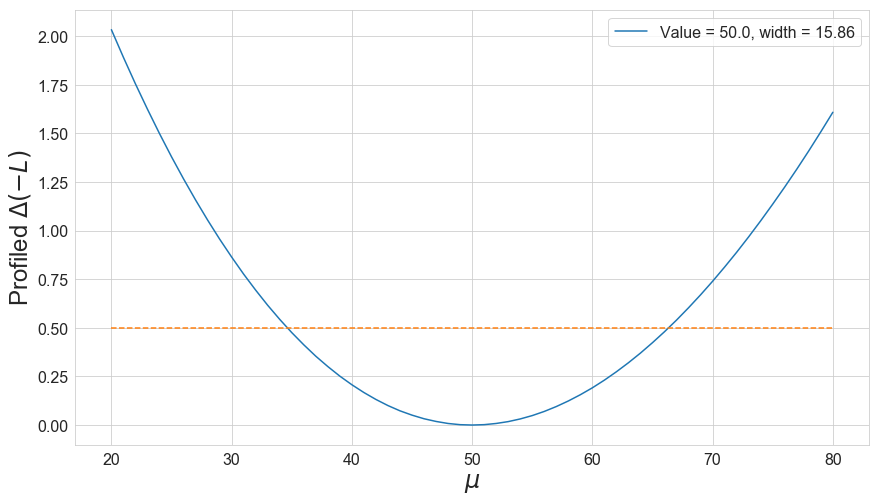

In [40]:
from pytorch_inferno.plotting import plot_likelihood
plot_likelihood(nll-nll.min())

In [part-3](https://gilesstrong.github.io/website/statistics/hep/inferno/2020/12/18/inferno-3.html#No-nuisance-parameters) our cross-entropy classifier achieved a width of 15.02, so INFERNO performs just slightly worse when no nuisances are present, however that's still not bad considering that the DNN was trained to expect nuisances to be present.

### Nuisance parameters

#### Shape variations

As before, we need to compute all the shifts in the background PDF. Following the paper, $r$ is shifted by $\pm0.2$, and $\lambda$ by $\pm0.5$. Remember that these shifts only affect the background process. [get_paper_syst_shapes](https://gilesstrong.github.io/pytorch_inferno/inference.html#get_paper_syst_shapes) will shift the data, recompute the new model predictions, and then compute the new PDF for background.

In [46]:
from pytorch_inferno.inference import get_paper_syst_shapes
bkg = test.dataset.x[test.dataset.y.squeeze() == 0]  # Select the background test data
b_shapes = get_paper_syst_shapes(bkg, df, model=model, pred_cb=InfernoPred())

Running: r=-0.2


Running: r=0


Running: r=0.2


Running: l=2.5


Running: l=3


Running: l=3.5


The function also saves the new predicted bin to the DataFrame, allowing us to see how the background shifts compared to the nominal prediction.

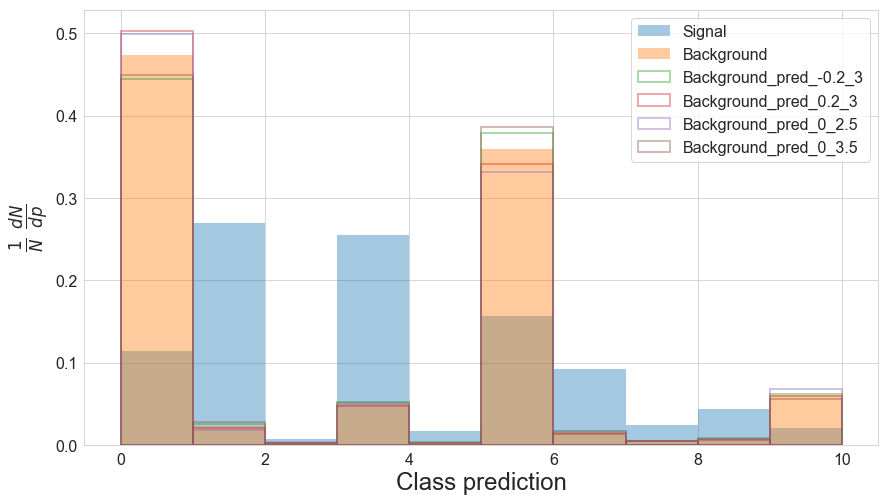

In [47]:
plot_preds(df, pred_names=['pred', 'pred_-0.2_3', 'pred_0.2_3', 'pred_0_2.5', 'pred_0_3.5'], bin_edges=np.linspace(0,10,11))

Following our interpretation of the binning earlier, it seems possible that the aim of herding the majority of the background into a few bins was to increase the number of bins which are less affected by the systematic shifts.

#### Benchmark 2

In benchmark 2 we allow the $r$ and $\lambda$ parameters to float.

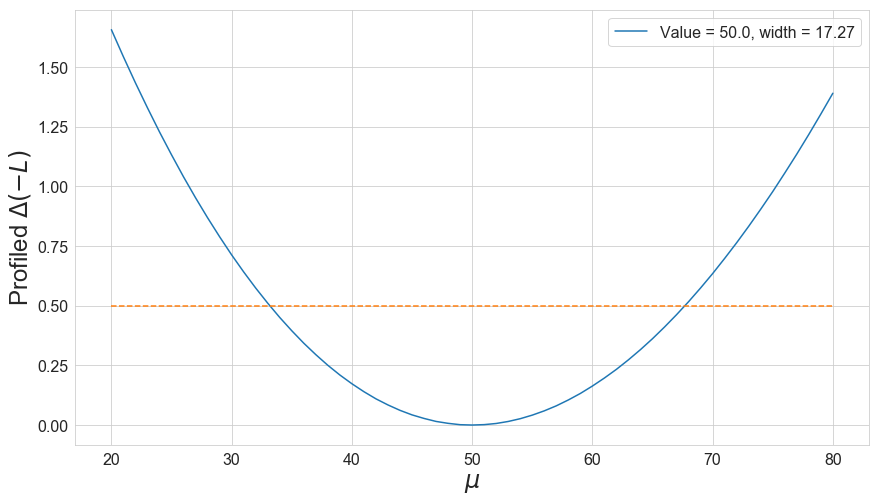

In [48]:
%%capture --no-display
from pytorch_inferno.inference import calc_profile
profiler = partialler(calc_profile, f_s=f_s, n=1050, mu_scan=torch.linspace(20,80,61), true_mu=50, n_steps=100)
nll = profiler(**b_shapes).cpu().detach()
plot_likelihood(nll-nll.min())

Wow! So [previously](https://gilesstrong.github.io/website/statistics/hep/inferno/2020/12/18/inferno-3.html#Benchmark-2) introducing these shape nuisances caused the width to jump up to ~24.5 (a ~60% increase), whereas with INFERNO the width only increases by about 10%.

#### Benchmark 3

Benchmark 3 is similar to BM2, except we introduce auxiliary measurements on the shapes.

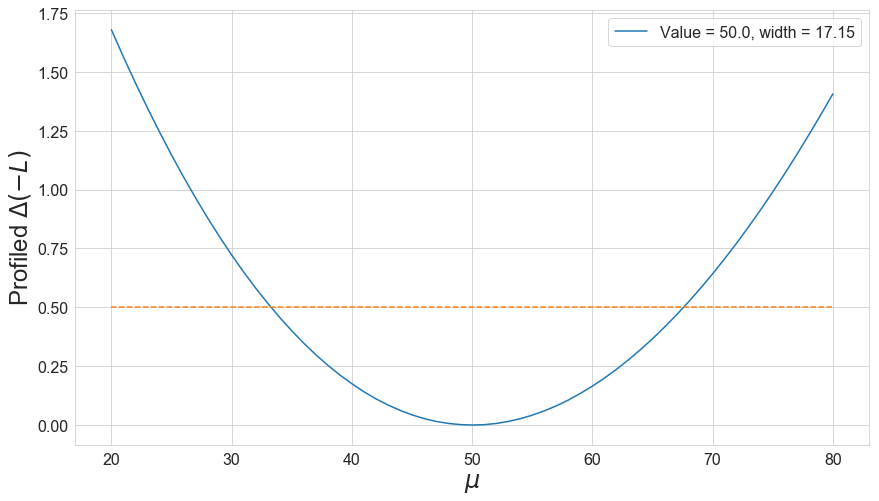

In [49]:
%%capture --no-display
alpha_aux = [torch.distributions.Normal(0,2), torch.distributions.Normal(0,2)]
nll = profiler(alpha_aux=alpha_aux, **b_shapes).cpu().detach()
plot_likelihood(nll-nll.min())

The constraints restore some sensitivity, but not as much as we saw for the [cross-entropy classifier](https://gilesstrong.github.io/website/statistics/hep/inferno/2020/12/18/inferno-3.html#Benchmark-3). The width is still much smaller, though.

#### Benchmark 4 - Normalisation uncertainty

For the final benchmark, we also let the background yield be a nuisance parameter (with an auxiliary measurement)

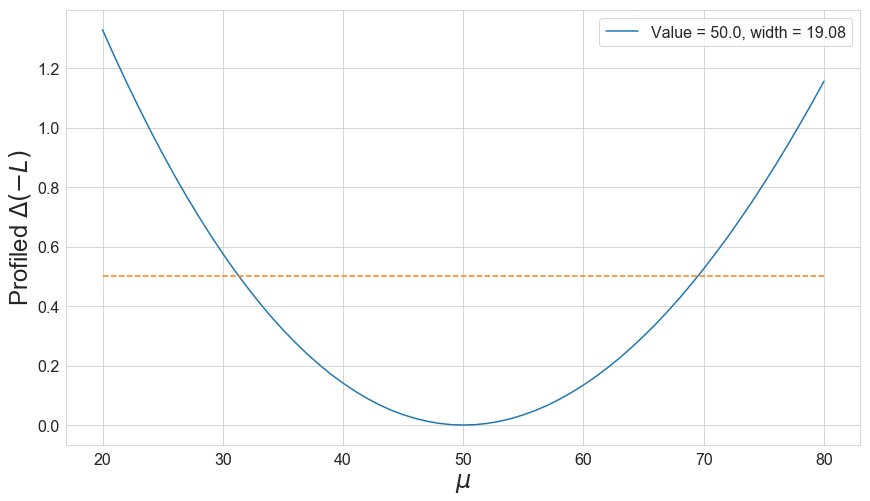

In [50]:
%%capture --no-display
nll = profiler(alpha_aux=alpha_aux, float_b=True, b_aux=torch.distributions.Normal(1000,100), **b_shapes).cpu().detach()
plot_likelihood(nll-nll.min())

The [cross-entropy classifier](https://gilesstrong.github.io/website/statistics/hep/inferno/2020/12/18/inferno-3.html#Normalisation-uncertainty) really struggled with this, resulting in a width of 27.74 (~85% increase). INFERNO does much better, with an increase of only ~20%. That's pretty good!

## Closing

By the end of the last post we weren't in a particularly good situation: we'd taken on a simple toy problem and trained a nice powerful classifier using the typical approaches of HEP, however the moment that we introduced systematic uncertainties on parts of our statistical model, the precision of our measurement fell apart. We had trained our model on a surrogate classification task, but the actual problem we wanted to solve was one of statistical inference.

What we've seen in this post is that by training the DNN to perform the actual task, rather than a surrogate task, and considering all the elements that go into the inference, we can arrive at a model which has learnt to be more resilient to the effects of nuisance parameters. On the most difficult benchmark, INFERNO provides a ~30% smaller width than the cross-entropy classifier.

I've also presented here a way of implementing INFERNO that can be plugged into an existing DNN training scheme, without having to write an entirely new training loop. Granted, the training loop contains more callback flexibility than one would traditionally implement, but why not have this extra flexibility? In my other DNN framework, [LUMIN](https://lumin.readthedocs.io/en/stable/), I recently upgraded the callback system to include these extra calls, and it's certainly simplified a lot of the code. I'll be including an implementation of INFERNO there, too, eventually.

One issue with current setup, however, is that we need to be able to modify the input features in a continuous manner; i.e. we need to either know exactly how each nuisance parameter affects the inputs, or we need to model their affects accurately. In part 5 I'll present a way in which we can avoid this and still apply INFERNO.

Another point is that the comparison between INFERNO and cross-entropy isn't strictly accurate. In INFERNO we effectively let the DNN decide how to bin the data, whereas for the cross-entropy we imposed a binning of 10 equally sizes bins and it could well be that using different sized bins might provide a better result. Possibly as a part 6 I'll revisit this and optimise the cross-entropy binning to get a better comparison.